# Data Analysis

## Dataframes Overview

In [286]:
# import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [287]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio Dataframe

The dataframe has 10 rows, each corresponding to a different offer. Each offer has a unique id and includes:
* 3 offer types:
  * BOGO (buy one, get one)
  * Discount
  * Informational
* 4 channels:
  * web
  * email
  * mobile
  * social

The third column (**difficulty**) represents the amount a person has to spend to complete the offer. Once the offer is completed, the person receives the amount specified in the first column (**reward**).

The data in these two columms is consistent with the offer type:
* For bogo offers, the difficulty and reward are the same.
* for discount offers, the difficulty amount is higher that the reward.
* For informational offers, there is no value in either difficulty or reward columns.

The fourth column (**duration**) is the time available for a person to complete the offer. For informational offers, this duration indicates how long the customer is assumed to feel the influence of the offer.

In [288]:
print('The portfolio dataframe has:\n{} rows\n{} columns'.format(portfolio.shape[0], portfolio.shape[1]))

The portfolio dataframe has:
10 rows
6 columns


In [289]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [290]:
# Create a new dataframe with the deatils of each offer
pf_details = portfolio[['id', 'offer_type', 'reward', 'difficulty', 'duration']].apply(
    lambda row: {
        'offer_type': row['offer_type'],
        'reward': row['reward'],
        'difficulty': row['difficulty'],
        'duration': row['duration'] * 24 # transform days to hours to match time column
    }, axis=1)

portfolio_details = pd.DataFrame({
    'id': portfolio['id'],
    'details': pf_details
})

In [291]:
portfolio_details

,id,details
0,ae264e3637204a6fb9bb56bc8210ddfd,"{'offer_type': 'bogo', 'reward': 10, 'difficul..."
1,4d5c57ea9a6940dd891ad53e9dbe8da0,"{'offer_type': 'bogo', 'reward': 10, 'difficul..."
2,3f207df678b143eea3cee63160fa8bed,"{'offer_type': 'informational', 'reward': 0, '..."
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,"{'offer_type': 'bogo', 'reward': 5, 'difficult..."
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,"{'offer_type': 'discount', 'reward': 5, 'diffi..."
5,2298d6c36e964ae4a3e7e9706d1fb8c2,"{'offer_type': 'discount', 'reward': 3, 'diffi..."
6,fafdcd668e3743c1bb461111dcafc2a4,"{'offer_type': 'discount', 'reward': 2, 'diffi..."
7,5a8bc65990b245e5a138643cd4eb9837,"{'offer_type': 'informational', 'reward': 0, '..."
8,f19421c1d4aa40978ebb69ca19b0e20d,"{'offer_type': 'bogo', 'reward': 5, 'difficult..."
9,2906b810c7d4411798c6938adc9daaa5,"{'offer_type': 'discount', 'reward': 2, 'diffi..."


### Profile Dataframe

The columns of this dataframe represent:
* gender: (str) M for masculine, F for femenine, O for other, or null
* age: (int) missing value encoded as 118
* id: (str/hash)
* became_member_on: (int) date format YYYYMMDD
* income: (float)

In [292]:
print('The profile dataframe has:\n{} rows\n{} columns'.format(profile.shape[0], profile.shape[1]))

The profile dataframe has:
17000 rows
5 columns


In [293]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


A first step will be convert the int in became_member_on to a proper date and replace the 118 in age with NaN.

In [294]:
# Replace 118 with NaN in the age column.
profile['age'] = profile['age'].replace(118, np.nan)

# for clarity replace F with Female, M with Male and O with Other in gende column
profile['gender'] = profile['gender'].replace({'F': 'Female', 'M': 'Male', 'O': 'Other'})

# Transform became_member_on to a date
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [295]:
display(profile.describe())

,age,became_member_on,income
count,14825.000000,17000,14825.000000
mean,54.393524,2017-02-23 13:12:10.164706048,65404.991568
min,18.000000,2013-07-29 00:00:00,30000.000000
25%,42.000000,2016-05-26 00:00:00,49000.000000
50%,55.000000,2017-08-02 00:00:00,64000.000000
75%,66.000000,2017-12-30 00:00:00,80000.000000
max,101.000000,2018-07-26 00:00:00,120000.000000
std,17.383705,NaN,21598.299410


In [296]:
# Check columns with Nan values
nans_columns = profile.isnull().mean()
print('Percentaje of missing values per column:\n{}'.format(nans_columns.sort_values(ascending=False)))

Percentaje of missing values per column:
gender              0.127941
age                 0.127941
income              0.127941
id                  0.000000
became_member_on    0.000000
dtype: float64


There is a 12.8% of persons without data in their profiles. For dealing with these missing values, instead of droping them, all these persons will form one of the demographic groups. As it could be interesting to study if the people who fill in their information interact in a different way with the offers.

### Transcript Dataframe

In this dataframe:
* person: (str/hash)
* event: (str) 
  * offer received
  * offer viewed
  * transaction
  * offer completed
* value: (dictionary) different values depending on event type
  * offer id: (str/hash) not associated with any "transaction"
  * amount: (int) money spent in "transaction"
  * reward: (int) money gained from "offer completed"
* time: (numeric) hours after start of test. The data begins at time t=0.

In [297]:
print('The transcript dataframe has:\n{} rows\n{} columns'.format(transcript.shape[0], transcript.shape[1]))

The transcript dataframe has:
306534 rows
4 columns


In [298]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Demographic Groups

In this section the data from the profile dataframe will be used to stablish a set of demographic groups based on gender, income and gender.

In [299]:
# New dataframe without the NaN values

profile_full = profile.dropna()

## Single Variable Analysis

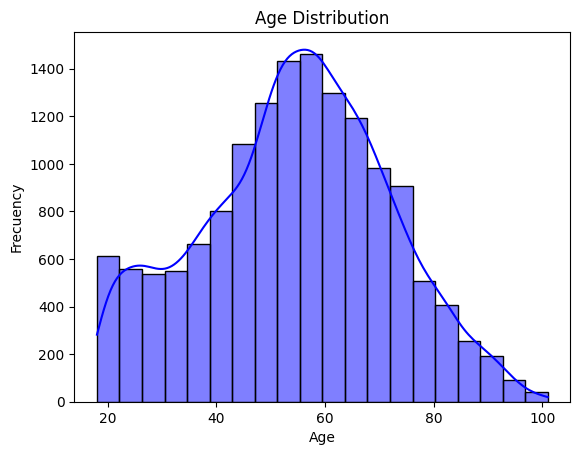

In [300]:
# Age
sns.histplot(profile_full["age"], bins=20, kde=True, color="blue")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frecuency")
plt.show()

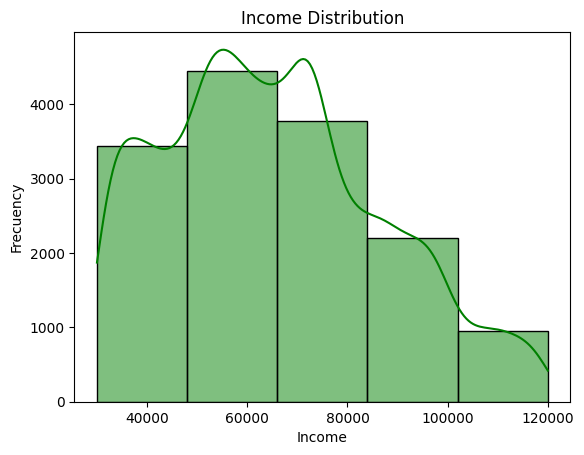

In [301]:
# Income
sns.histplot(profile_full["income"], bins=5, kde=True, color="green")
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Frecuency")
plt.show()

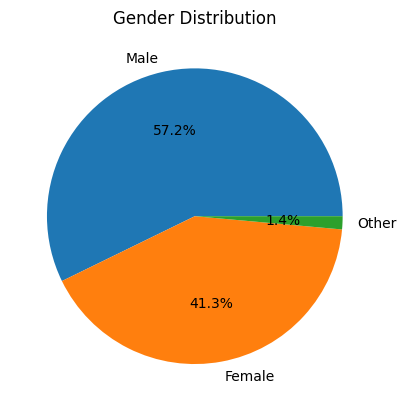

In [302]:
# Gender
profile_full["gender"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Gender Distribution")
plt.ylabel("")
plt.show()

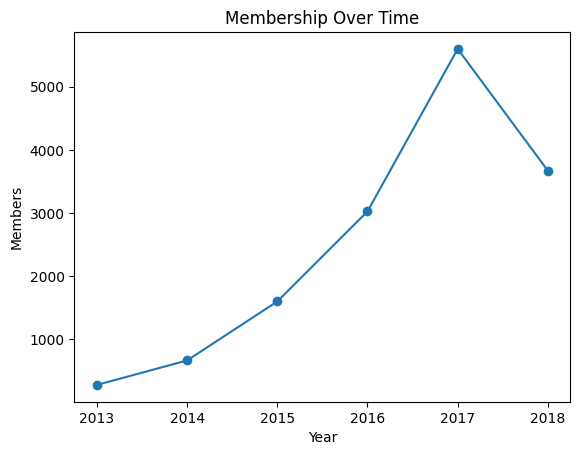

In [303]:
# Membership
profile_full["became_member_on"].dt.year.value_counts().sort_index().plot(kind="line", marker="o")
plt.title("Membership Over Time")
plt.xlabel("Year")
plt.ylabel("Members")
plt.show()

## Demographic Groups Definition

The data will be split in the following demographic groups:
* Age: 
  * Young adults if age < 25
  * Adults if 25 <= age < 65
  * Seniors if age >= 65
* Income
  * Low if income < 45000
  * Middle if 45000 <= income < 80000
  * High if income >= 

This will turn into a new DataFrame with user ids, age group, income group and gender. For the users that did't input their data the NaN values will be replaced with "Unknown".

In [304]:
def categorize_age(age):
    '''
    Clasifies age in three categories.
    INPUT:
    age - int representing the age of a person

    OUTPUT:
    age_group - str representing the demographic group
    '''
    age_group = ""

    if age < 25:
        age_group = "Young Adult"
    elif 25 <= age < 65:
        age_group = "Middle-Age"
    else:
        age_group = "Senior"

    return age_group

def categorize_income(income):
    '''
    Clasifies income in three categories.
    INPUT:
    income - int representing the annual income of a person

    OUTPUT:
    income_group - str represeting the demographic group
    '''
    income_group = ""
    if income < 45000:
        income_group = "Low Income"
    elif 45000 <= income < 80000:
        income_group = "Middle Income"
    else:
        income_group = "High Income"

    return income_group

profile_clean = profile.fillna({'gender': 'Unknown', 'age': 'Unknown', 'income': 'Unknown'})

profile_clean.loc[:, "age_group"] = profile_clean["age"].apply(lambda x: categorize_age(x) if isinstance(x, (int, float)) else 'Unknown')
profile_clean.loc[:, "income_group"] = profile_clean["income"].apply(lambda x: categorize_income(x) if isinstance(x, (int, float)) else 'Unknown')

profile_groups = profile_clean[['id', 'gender', 'age_group', 'income_group']]

# Count of each group
print(profile_groups.groupby(["gender", "age_group", "income_group"]).size())

gender   age_group    income_group 
Female   Middle-Age   High Income      1252
                      Low Income        525
                      Middle Income    2048
         Senior       High Income       910
                      Low Income        222
                      Middle Income     934
         Young Adult  Low Income         85
                      Middle Income     153
Male     Middle-Age   High Income       946
                      Low Income       1354
                      Middle Income    3412
         Senior       High Income       556
                      Low Income        382
                      Middle Income    1205
         Young Adult  Low Income        261
                      Middle Income     368
Other    Middle-Age   High Income        42
                      Low Income         28
                      Middle Income      76
         Senior       High Income        11
                      Low Income         10
                      Middle Income     

## Offer Funnel

The expected offer funnel for discount and bogo offers would be as follows:
1. Offer received
2. Offer viewed
3. Transaction
4. Offer completed

For informational offers, there is no completion stage.

There will be cases where a offer is recived but never viewed:
1. Offer received
2. Transaction
3. Offer completed

Additionally, some discount and BOGO offers may never be completed:
1. Offer received
2. Offer viewed
3. Transaction

Some offers may be opened but not lead to any transactions::
1. Offer received
2. Offer viewed
3. Transaction

Last, there could be transactions that aren't linked to any offer:
1. Transaction

For the purpose of this analysis offers will be classified as follows:
* Type I offers: Offers that follow the funnel to completion
* Type II offers: Offers that are received, viewed and led to a transaction, but never completed
* Type III offers: Offers that are received and viewed but have no associated transactions.
* Type IV offers: Offers that are received but never opened

In [305]:
# expland the dictionary in columns
transcript_expand = transcript['value'].apply(pd.Series)

# add the remaining columns from transcript
transcript_expand = pd.concat([transcript[['person']], transcript[['event']], transcript_expand, transcript[['time']]], axis = 1)

# offer id and offer_id columns after expanding need to be merged in one
transcript_expand['offer_id'] = transcript_expand[['offer id', 'offer_id']].bfill(axis=1).iloc[:,0]

# drop offer_id and rename offer id
transcript_expand = transcript_expand.drop(columns=['offer_id'])
transcript_expand = transcript_expand.rename(columns={'offer id' : 'offer_id'})

# for the purpose of this analysis, it's irrelevant if an offer is completed
# drop all offer completed rows
transcript_expand = transcript_expand.drop(transcript_expand[transcript_expand['event'] == 'offer completed'].index)
# drop reward column (is only NaN now)
transcript_expand = transcript_expand.drop('reward', axis=1)

In [306]:
transcript_expand.head()

,person,event,offer_id,amount,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0


In [307]:
# merge the details of the offers from the portfolio dataframe
transcript_log = transcript_expand.merge(portfolio_details[['id', 'details']], left_on='offer_id', right_on='id', how='left')
transcript_log = transcript_log.drop(columns=['id'])

In [308]:
# sort log by person and time
log = transcript_log.sort_values(by=['person','time'], ascending=True)

# Add expiry time to offers received
log['details'] = log.apply(lambda row: {**row['details'], 'expiry': row['time'] + row['details']['duration']} 
                           if isinstance(row['details'], dict) and row['event'] == 'offer received' 
                           else row['details'], axis=1)


In [309]:
log.head()

,person,event,offer_id,amount,time,details
51314,0009655768c64bdeb2e877511632db8f,offer received,5a8bc65990b245e5a138643cd4eb9837,NaN,168,"{'offer_type': 'informational', 'reward': 0, '..."
71545,0009655768c64bdeb2e877511632db8f,offer viewed,5a8bc65990b245e5a138643cd4eb9837,NaN,192,"{'offer_type': 'informational', 'reward': 0, '..."
81334,0009655768c64bdeb2e877511632db8f,transaction,NaN,22.16,228,NaN
103438,0009655768c64bdeb2e877511632db8f,offer received,3f207df678b143eea3cee63160fa8bed,NaN,336,"{'offer_type': 'informational', 'reward': 0, '..."
127578,0009655768c64bdeb2e877511632db8f,offer viewed,3f207df678b143eea3cee63160fa8bed,NaN,372,"{'offer_type': 'informational', 'reward': 0, '..."


In [310]:
# Add two new columns with the list of live offers and active offers
# an offer is live when its received
# an offer is active when its viewed

def filter_expired_offers(offers_list, time):
    '''
    Filters a list of dictionaries
    INPUT:
    offers_list - list of dictionaries with the elements to filter
    time - fitering variable

    OUTPUT:
    live_offer_list - list of dictionaries filtered by time
    '''
    live_offer_list = []
    if isinstance(offers_list, list):
        live_offer_list = [
            (offer_id, t, details) for offer_id, t, details in offers_list
            if t <= time < details['expiry']
        ]
    return live_offer_list

def add_active_offer(index, live_offers, offers_viewed):
    '''
    Filters a list of dictionaries
    INPUT:
    offers_list - list of dictionaries with the elements to filter
    offer_viewed_id - id of the offer to find
    view_time - time when the offer was viewed

    OUTPUT:
    active_offer_list - list of dictionaries filtered
    '''
    active_offer_list = []
    viewed_dict = {offer_id: t for offer_id, t, _ in offers_viewed}

    if isinstance(live_offers, list) and isinstance(offers_viewed, list): # check live_offers and offers_viewed aren't NaN
        active_offer_list = [
            (offer_id, t, details) for offer_id, t, details in live_offers
            if offer_id in viewed_dict and viewed_dict[offer_id] > t]

    return active_offer_list

def new_column_event(df, event):
    '''
    Adds a new column to df defined by event
    INPUT:
    df - a transcript log dataframe with events
    event - the required event for the new column

    OUTPUT:
    active_offer_list - list of dictionaries filtered
    '''
    # Step 1: extract all offers by event
    offer_by_event = df[df['event'] == event]

    # Step 2: Aggregate by person the offers viewed, extract details, offer id and time when was viewed
    offers_by_event_by_person = offer_by_event.groupby('person').apply(
        lambda x: [(offer_id, time, details) for offer_id, time, details in zip(x['offer_id'], x['time'], x['details'])],
        include_groups=False
    ).reset_index(name=event)

    # Step 3: Merge the offers list back to the log dataframe (for easy lookup)
    df = df.merge(offers_by_event_by_person, on='person', how='left')

    # Step 4: Filter the offers and add the final column
    if event == 'offer received':
        df['live_offers'] = df.apply(lambda row: filter_expired_offers(row[event], row['time']), axis=1)
    elif event == 'offer viewed':
        if 'live_offers' in df.columns:
            df['active_offers'] = df.apply(
                lambda row: add_active_offer(row['person'], row['live_offers'], row[event])
                if isinstance(row['live_offers'], list) and isinstance(row[event], list)
                else [],
                axis=1
            )
    
    # Step 5: drop auxiliary column
    df.drop(columns=event, inplace=True)

    return df

In [311]:
log = new_column_event(log, 'offer received')

In [312]:
log = new_column_event(log, 'offer viewed')

In [313]:
log.head()

,person,event,offer_id,amount,time,details,live_offers,active_offers
0,0009655768c64bdeb2e877511632db8f,offer received,5a8bc65990b245e5a138643cd4eb9837,NaN,168,"{'offer_type': 'informational', 'reward': 0, '...","[(5a8bc65990b245e5a138643cd4eb9837, 168, {'off...","[(5a8bc65990b245e5a138643cd4eb9837, 168, {'off..."
1,0009655768c64bdeb2e877511632db8f,offer viewed,5a8bc65990b245e5a138643cd4eb9837,NaN,192,"{'offer_type': 'informational', 'reward': 0, '...","[(5a8bc65990b245e5a138643cd4eb9837, 168, {'off...","[(5a8bc65990b245e5a138643cd4eb9837, 168, {'off..."
2,0009655768c64bdeb2e877511632db8f,transaction,NaN,22.16,228,NaN,"[(5a8bc65990b245e5a138643cd4eb9837, 168, {'off...","[(5a8bc65990b245e5a138643cd4eb9837, 168, {'off..."
3,0009655768c64bdeb2e877511632db8f,offer received,3f207df678b143eea3cee63160fa8bed,NaN,336,"{'offer_type': 'informational', 'reward': 0, '...","[(3f207df678b143eea3cee63160fa8bed, 336, {'off...","[(3f207df678b143eea3cee63160fa8bed, 336, {'off..."
4,0009655768c64bdeb2e877511632db8f,offer viewed,3f207df678b143eea3cee63160fa8bed,NaN,372,"{'offer_type': 'informational', 'reward': 0, '...","[(3f207df678b143eea3cee63160fa8bed, 336, {'off...","[(3f207df678b143eea3cee63160fa8bed, 336, {'off..."


In [317]:

# Step 7: clean 'live_offers' to keep only the offer name
# transcript_log['live_offers'] = transcript_log['live_offers'].apply(lambda x: [offer[0] for offer in x] if isinstance(x, list) else [])
